# Setting up the Environment



In [0]:
%%writefile requirements.txt
torch 
torchvision
Pillow
pandas==1.0.3
numpy==1.18.4
scipy==1.4.1
scikit-image==0.17.2
tqdm==4.46.0
matplotlib==3.2.1

Writing requirements.txt


In [0]:
# !pip install -r requirements.txt

---
# 01. Problem Statement
The problem statement that is to presented us is of **Image Segmentation**. The image segmentation is usually defined as the process of dividing the image into multiple sections so that it becomes very easy analyze for the system and more details can be extracted from the image.

## Dataset
The dataset we have for this problem is the **Oxford IIIT Pet Dataset**. In the dataset, we have 37 categories of pets and around 200 images for each category of pet.

## Approach
The neural network architecture we will use to solve this problem is the [U-Net](https://arxiv.org/abs/1505.04597). Specifically developed for biomedical image segmentation, the U-Net out performs other architectures in the same domain. The **U-Net** consist a the contracting path to capture the context of the image and a symmetric expanding path to enables precise localization. 

In [39]:
# importing the libraries
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img, array_to_img, img_to_array
import PIL
from PIL import ImageOps
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
keras.backend.clear_session()
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


# 02. Loading the Dataset

In [2]:
# defining the root directory path and data folders
root_dir = "drive/My Drive/oxford-iiit-pet-dataset"
input_folder = "images"
annot_folder = "annotations/trimaps"

input_dir = os.path.join(root_dir, input_folder)
annot_dir = os.path.join(root_dir, annot_folder)

img_size = (160, 160)     # a tuple defining size of the image
n_classes = 37

# the following list comprehension reads the filenames from the input folder
# we are putting a condition that filname must contain ".jpg" as there are some ".mat" files also in the same folder
input_paths = [os.path.join(input_dir, i) for i in os.listdir(input_dir) if i.endswith(".jpg") and not i.endswith("(1).jpg")]
annot_paths = [os.path.join(annot_dir, i) for i in os.listdir(annot_dir) if i.endswith(".png") and not (i.startswith(".") or i.endswith("(1).png"))] 

# sorting the input paths as it will be handy in creating a zip
input_paths, annot_paths = sorted(input_paths), sorted(annot_paths)
print("input_paths = {}".format(len(input_paths)))
print("annot_paths = {}".format(len(annot_paths)))

# verifying the paths
count = 0
for i, j in zip(input_paths, annot_paths):
    print("{} --> {}".format(i, j))
    if count == 5:
        break
    count += 1

input_paths = 7390
annot_paths = 7390
drive/My Drive/oxford-iiit-pet-dataset/images/Abyssinian_1.jpg --> drive/My Drive/oxford-iiit-pet-dataset/annotations/trimaps/Abyssinian_1.png
drive/My Drive/oxford-iiit-pet-dataset/images/Abyssinian_10.jpg --> drive/My Drive/oxford-iiit-pet-dataset/annotations/trimaps/Abyssinian_10.png
drive/My Drive/oxford-iiit-pet-dataset/images/Abyssinian_100.jpg --> drive/My Drive/oxford-iiit-pet-dataset/annotations/trimaps/Abyssinian_100.png
drive/My Drive/oxford-iiit-pet-dataset/images/Abyssinian_101.jpg --> drive/My Drive/oxford-iiit-pet-dataset/annotations/trimaps/Abyssinian_101.png
drive/My Drive/oxford-iiit-pet-dataset/images/Abyssinian_102.jpg --> drive/My Drive/oxford-iiit-pet-dataset/annotations/trimaps/Abyssinian_102.png
drive/My Drive/oxford-iiit-pet-dataset/images/Abyssinian_103.jpg --> drive/My Drive/oxford-iiit-pet-dataset/annotations/trimaps/Abyssinian_103.png


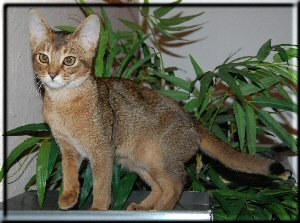

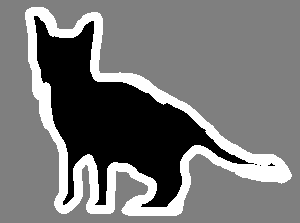

In [0]:
# checking what does an input image and it's corresponding trimap looks like
display(Image(input_paths[71]))
PIL.ImageOps.autocontrast(load_img(annot_paths[71]))

---
# 02. Model Building

### Create a dataloader class

In [0]:
class Dataloader(keras.utils.Sequence):
    """
    helper class to iterate over the data
    """
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, index):
        """
        returns tuple (input, target) corresponds to the batch index
        """
        i = index * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i+self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype = "float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype = "uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size = self.img_size, color_mode = "grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

## Define U-Net architecture

In [0]:
def u_net(img_size, n_classes):
    """
    the function defines the U-Net style architecture

    args: img_size (size of the image)
          n_classes (number of classes)
    returns: model 
    """
    input_ = keras.Input(shape = img_size + (3,))

    ###########################################
    ## Contractor Path - First half of U-Net ##
    ###########################################

    x = layers.Conv2D(32, 3, strides = 2, padding = "same")(input_)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    # apart from the feature depths, the blocks 1, 2, 3 are identical to one another
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

        # residuals
        resid = layers.Conv2D(filters, 1, strides = 2, padding = "same")(
            previous_block_activation
        )
        x = layers.add([x, resid])    # add resid block
        previous_block_activation = x
    
    ###########################################
    ## Expanding Path - Second half of U-Net ##
    ###########################################
    previous_block_activation = x    # residual
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)


        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # residuals
        resid = layers.UpSampling2D(2)(previous_block_activation)
        resid = layers.Conv2D(filters, 1, padding = "same")(resid)
        x = layers.add([x, resid])
        previous_block_activation = x 

    # Add a pixel level classification layer
    output_ = layers.Conv2D(n_classes, 3, 
                            activation = "softmax", 
                            padding = "same")(x)
    unet_model = keras.Model(input_, output_)
    return unet_model

In [0]:
unet_model = u_net(img_size = img_size, n_classes = n_classes)

In [0]:
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 80, 80, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 80, 80, 32)   128         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 80, 80, 32)   0           batch_normalization_76[0][0]     
____________________________________________________________________________________________

---
# 04. Model Training

In [4]:
# split our img paths into a training and a testing set
test_samples = int(0.3 * len(input_paths))
random.Random(42).shuffle(input_paths)
random.Random(42).shuffle(annot_paths)
train_input_paths = input_paths[:-test_samples]
train_annot_paths = annot_paths[:-test_samples]
testset_input_paths = input_paths[-test_samples:]
testset_annot_paths = annot_paths[-test_samples:]

# split our img paths into a training and a validation set
valid_samples = int(0.1 * len(train_input_paths))
random.Random(42).shuffle(train_input_paths)
random.Random(42).shuffle(train_annot_paths)
trainset_input_paths = train_input_paths[:-valid_samples]
trainset_annot_paths = train_annot_paths[:-valid_samples]
validset_input_paths = train_input_paths[-valid_samples:]
validset_annot_paths = train_annot_paths[-valid_samples:]

print("Train Samples ... {}, {}".format(len(trainset_input_paths), len(trainset_annot_paths)))
print("Valid Samples ... {}, {}".format(len(validset_input_paths), len(validset_annot_paths)))
print("Test Samples ... {}, {}".format(len(testset_input_paths), len(testset_annot_paths)))

Train Samples ... 4656, 4656
Valid Samples ... 517, 517
Test Samples ... 2217, 2217


In [0]:
batch_size = 32
epochs = 15

train_generator = Dataloader(batch_size, img_size, trainset_input_paths, trainset_annot_paths)
valid_generator = Dataloader(batch_size, img_size, validset_input_paths, validset_annot_paths)
test_generator = Dataloader(batch_size, img_size, testset_input_paths, testset_annot_paths)

In [0]:
# configure the model for training
unet_model.compile(optimizer = "rmsprop", 
                   loss = "sparse_categorical_crossentropy")
checkpoint_path = os.path.join(root_dir, "checkpoint", "oxford_segmentation.h5")
callbacks = [keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                             save_best_only = True)]

model_history = unet_model.fit(train_generator, 
                               epochs = epochs, 
                               validation_data = valid_generator, 
                               callbacks = callbacks)

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Epoch 1/15
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Execu

---
# 05. Model Prediction 

In [5]:
# load the saved model
checkpoint_path = os.path.join(root_dir, "checkpoint", "oxford_segmentation.h5")
unet_model = tf.keras.models.load_model(checkpoint_path)

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [0]:
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 80, 80, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 80, 80, 32)   128         conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 80, 80, 32)   0           batch_normalization_76[0][0]     
____________________________________________________________________________________________

In [6]:
batch_size = 8
test_generator = Dataloader(batch_size, (160, 160), testset_input_paths[:10], testset_annot_paths[:10])
test_preds = unet_model.predict(test_generator)

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_predict_function_4089 in device /job:localhost/replica:0/task:0/device:GPU:0


In [0]:

# plt.imshow(display([(PIL.ImageOps.autocontrast(load_img(testset_annot_paths[7], target_size = (160, 160), color_mode = "grayscale"))), (test_preds, 7)]))

---
# 06. Displaying the Results

In the following section, we are displaying the results of the model predictions on the test dataset. Because of the GPU's OOM issue, the prediction is done on only 10 test samples and we are displaying three results here.

In [0]:
def display_mask(img_arr, i):
    """
    helper function to display a model's prediction.
    """
    mask = np.argmax(img_arr[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

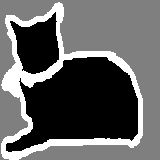

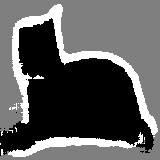

In [72]:
# real Image
display(PIL.ImageOps.autocontrast(load_img(testset_annot_paths[0], target_size = (160, 160), color_mode = "grayscale")))
# predicted Image
display_mask(test_preds, 0)

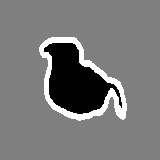

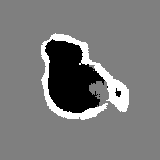

In [66]:
# real Image
display(PIL.ImageOps.autocontrast(load_img(testset_annot_paths[2], target_size = (160, 160), color_mode = "grayscale")))
# predicted Image
display_mask(test_preds, 2)

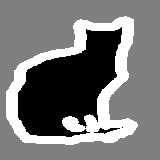

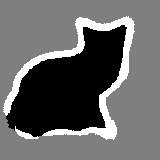

In [68]:
# real Image
display(PIL.ImageOps.autocontrast(load_img(testset_annot_paths[6], target_size = (160, 160), color_mode = "grayscale")))
# predicted Image
display_mask(test_preds, 6)

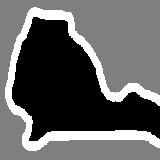

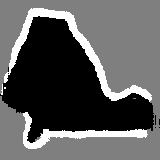

In [69]:
# real Image
display(PIL.ImageOps.autocontrast(load_img(testset_annot_paths[7], target_size = (160, 160), color_mode = "grayscale")))
# predicted Image
display_mask(test_preds, 7)